# CNN-LSTM for Unsafe Behavior Detection in Video  
**Author: May Cooper**

## Overview

This project uses a CNN-LSTM architecture implemented in Keras to classify human actions from video data and detect potentially unsafe pedestrian behaviors. The pipeline extracts spatial features using a pre-trained 2D CNN (VGG16) and models temporal dynamics with LSTM to recognize actions such as cliff diving, running, and climbing. The model is designed to support real-time safety monitoring in environments like construction zones and public surveillance systems.

**Research question:**  
Can unsafe pedestrian actions be automatically detected from video sequences using a CNN-LSTM model for improved safety monitoring?

## Goal

Build and evaluate a deep learning model for video-based action classification by:
1. Preprocessing video data into labeled frame sequences.
2. Extracting spatial features using a pre-trained CNN (VGG16).
3. Modeling temporal patterns with an LSTM network.
4. Training and evaluating the model with metrics such as accuracy, precision, recall, and F1-score.
5. Visualizing classification performance using confusion matrices and supporting real-time deployment readiness.

Filter Dataset

In [94]:
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define selected categories with corresponding IDs
selected_categories = {
    "BalanceBeam": 5,
    "Biking": 11,
    "CliffDiving": 22,
    "HandstandWalking": 38,
    "JumpingJack": 47,
    "JumpRope": 48,
    "LongJump": 51,
    "Lunges": 52,
    "RockClimbingIndoor": 74,
    "RopeClimbing": 75,
    "WalkingWithDog": 98
}

# Define input and output directories
input_dir = "data/splits"
output_dir = "filtered_data/splits"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

# list of input files to process
input_files = [
    "trainlist01.txt",
    "trainlist02.txt",
    "trainlist03.txt",
    "testlist01.txt",
    "testlist02.txt",
    "testlist03.txt"
]

# iterate through input files and filter dataset
for input_file in input_files:
    input_path = os.path.join(input_dir, input_file)
    output_path = os.path.join(output_dir, input_file)

    if not os.path.exists(input_path):
        logging.warning(f"File not found - {input_path}")
        continue

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for line in infile:
            # extract category from the path
            category = line.split("/")[0]
            if category in selected_categories:
                outfile.write(line)

    logging.info(f"Processed: {input_file}")

logging.info("Dataset filtering completed.")

INFO: Processed: trainlist01.txt
INFO: Processed: trainlist02.txt
INFO: Processed: trainlist03.txt
INFO: Processed: testlist01.txt
INFO: Processed: testlist02.txt
INFO: Processed: testlist03.txt
INFO: Dataset filtering completed.


Train-Validation-Test Split

In [95]:
import random
import os
import logging

# Paths
input_dir = "filtered_data/splits"
filtered_files = [
    os.path.join(input_dir, "trainlist01.txt"),
    os.path.join(input_dir, "trainlist02.txt"),
    os.path.join(input_dir, "trainlist03.txt")
]

# Split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

for file in filtered_files:
    with open(file, "r") as f:
        data = f.readlines()

    random.shuffle(data)
    train_end = int(len(data) * train_ratio)
    val_end = train_end + int(len(data) * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    base_name = os.path.basename(file)

    with open(f"train_split_{base_name}", "w") as train_file:
        train_file.writelines(train_data)
    logging.info(f"train_split_{base_name} created with {len(train_data)} records.")

    with open(f"val_split_{base_name}", "w") as val_file:
        val_file.writelines(val_data)
    logging.info(f"val_split_{base_name} created with {len(val_data)} records.")

    with open(f"test_split_{base_name}", "w") as test_file:
        test_file.writelines(test_data)
    logging.info(f"test_split_{base_name} created with {len(test_data)} records.")

logging.info("Train-validation-test split completed.")

INFO: train_split_trainlist01.txt created with 698 records.
INFO: val_split_trainlist01.txt created with 149 records.
INFO: test_split_trainlist01.txt created with 151 records.
INFO: train_split_trainlist02.txt created with 703 records.
INFO: val_split_trainlist02.txt created with 150 records.
INFO: test_split_trainlist02.txt created with 152 records.
INFO: train_split_trainlist03.txt created with 710 records.
INFO: val_split_trainlist03.txt created with 152 records.
INFO: test_split_trainlist03.txt created with 153 records.
INFO: Train-validation-test split completed.


INFO: Starting EDA: Counting how many videos per category in filtered splits...


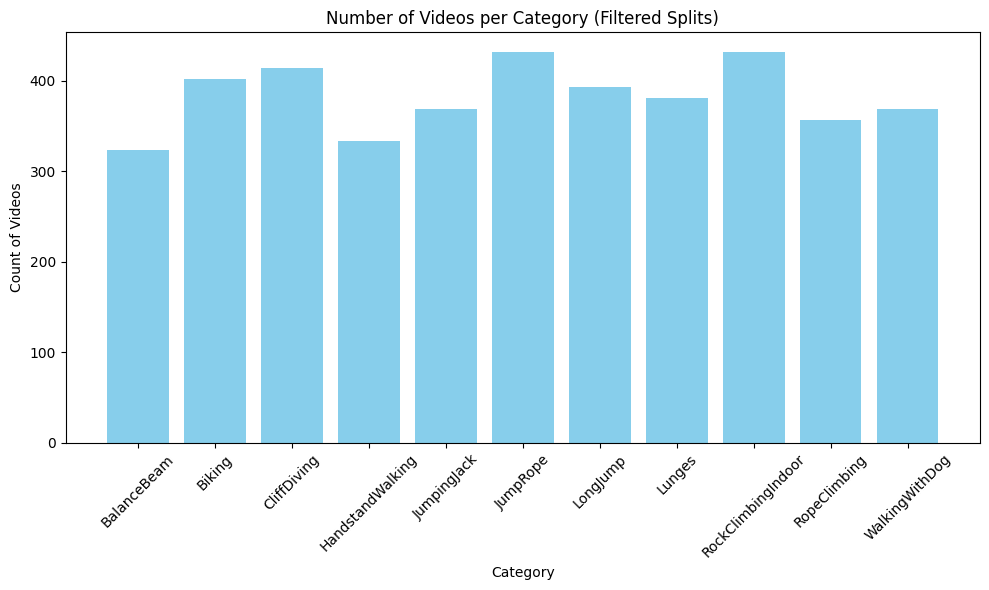

INFO: Video count distribution plotted.
INFO: EDA for video dataset completed.


In [96]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import logging

# Explanation of each sub-step:
# a) Train-Validation-Test Split: Already done above. This ensures we have separate data for training, validation, and testing.
# b) Split the videos into smaller segments or frames on specific activities: This will happen when we do frame extraction.
# c) Remove irrelevant or noisy frames from video segments: We will handle this in "Remove Noisy Frames" step.
# d) Adjust video frames to a consistent format (e.g., resizing): Handled in "Format Frames".
# e) Extract meaningful features from video frames: Handled in "Extract Features".
# f) Consider the sequence of video frames: We’ll do this in the "Sequence Preparation" step.

# Count how many videos per category in the filtered splits
logging.info("Starting EDA: Counting how many videos per category in filtered splits...")

filtered_splits_dir = "filtered_data/splits"
category_count = Counter()

for split_file in os.listdir(filtered_splits_dir):
    file_path = os.path.join(filtered_splits_dir, split_file)
    if os.path.isfile(file_path):
        with open(file_path, "r") as f:
            for line in f:
                category = line.split("/")[0]
                category_count[category] += 1

# Plot distribution of vvideos per category
categories = list(category_count.keys())
counts = list(category_count.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.title("Number of Videos per Category (Filtered Splits)")
plt.xlabel("Category")
plt.ylabel("Count of Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

logging.info("Video count distribution plotted.")

logging.info("EDA for video dataset completed.")

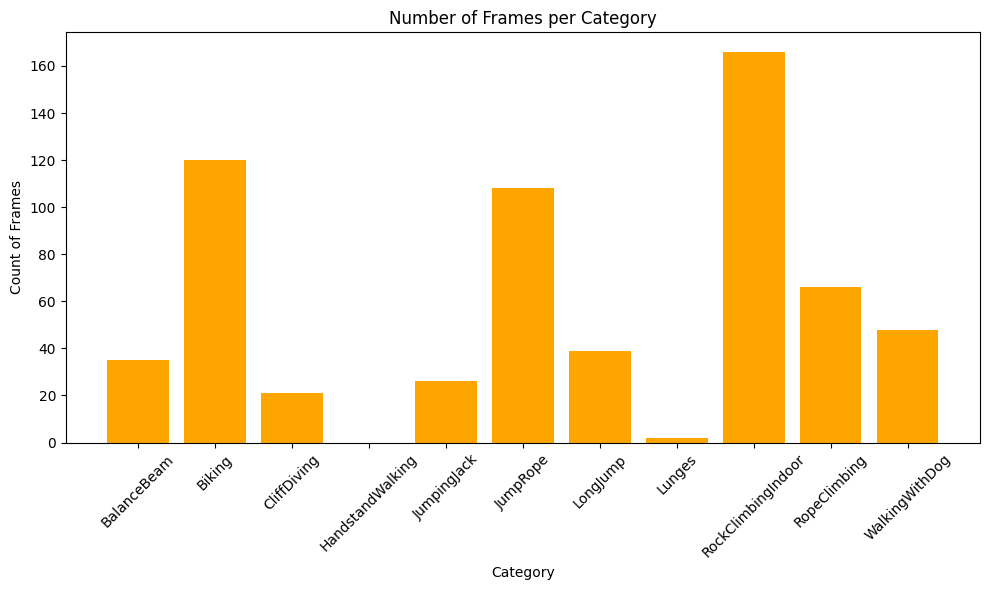

In [97]:
# distribution of extracted frames

frame_dir = 'data/frames'
frame_count = Counter()

for category in os.listdir(frame_dir):
    category_path = os.path.join(frame_dir, category)
    if os.path.isdir(category_path):
        num_frames = len(os.listdir(category_path))
        frame_count[category] = num_frames

categories_f = list(frame_count.keys())
counts_f = list(frame_count.values())

plt.figure(figsize=(10, 6))
plt.bar(categories_f, counts_f, color='orange')
plt.title("Number of Frames per Category")
plt.xlabel("Category")
plt.ylabel("Count of Frames")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

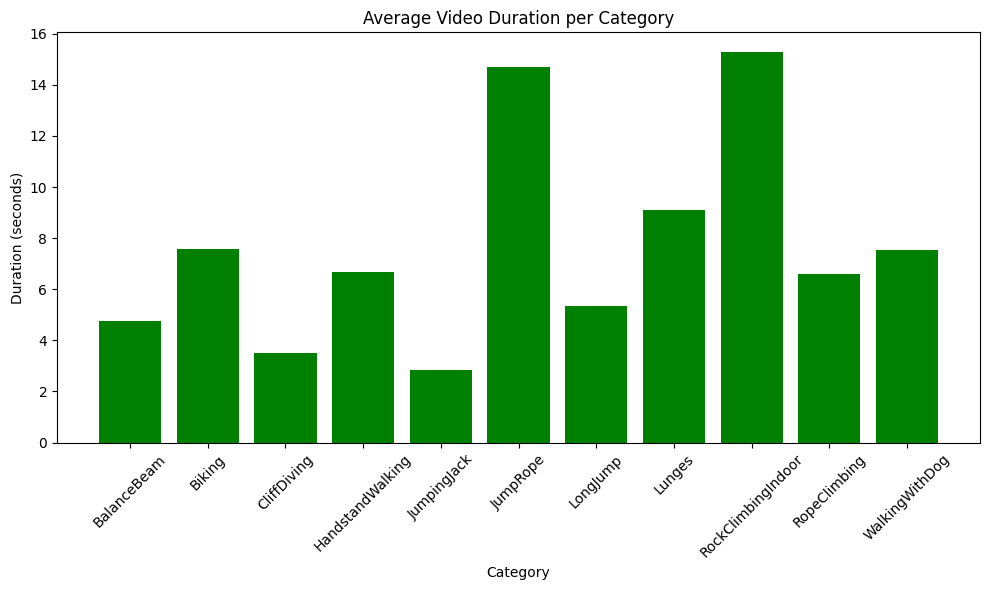

INFO: Plotted average video duration per category.


In [98]:
import cv2
import os
import matplotlib.pyplot as plt
import logging

video_dir = "data/UCF101"
category_durations = {}

for category in os.listdir(video_dir):
    category_path = os.path.join(video_dir, category)
    if os.path.isdir(category_path):
        total_duration = 0
        video_count = 0
        for video_file in os.listdir(category_path):
            video_path = os.path.join(category_path, video_file)
            cap = cv2.VideoCapture(video_path)
            if cap.isOpened():
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                duration = frame_count / fps if fps else 0
                total_duration += duration
                video_count += 1
            cap.release()
        if video_count > 0:
            avg_duration = total_duration / video_count
            category_durations[category] = avg_duration

# Plot avg duration per category
categories = list(category_durations.keys())
avg_durations = list(category_durations.values())

plt.figure(figsize=(10,6))
plt.bar(categories, avg_durations, color='green')
plt.title("Average Video Duration per Category")
plt.xlabel("Category")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

logging.info("Plotted average video duration per category.")

Extract Frames

In [99]:
import cv2
import os
import logging

# selected categories
selected_categories = {
    "BalanceBeam": 5,
    "Biking": 11,
    "CliffDiving": 22,
    "HandstandWalking": 38,
    "JumpingJack": 47,
    "JumpRope": 48,
    "LongJump": 51,
    "Lunges": 52,
    "RockClimbingIndoor": 74,
    "RopeClimbing": 75,
    "WalkingWithDog": 98
}

def extract_frames(video_path, output_dir, frame_rate=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Could not open video file: {video_path}. Skipping...")
        return

    count = 0
    success, frame = cap.read()

    while success:
        if count % frame_rate == 0:
            frame_filename = os.path.join(output_dir, f"frame_{count}.jpg")
            # save the frame
            try:
                cv2.imwrite(frame_filename, frame)
            except Exception as e:
                logging.error(f"Error writing frame {frame_filename}: {e}")

        success, frame = cap.read()
        count += 1

    cap.release()
    logging.info(f"Extraction completed for {video_path} with {count} frames processed.")

video_dir = "data/UCF101"
output_dir = "data/frames"
categories = list(selected_categories.keys())

for category in categories:
    category_dir = os.path.join(video_dir, category)
    if not os.path.exists(category_dir):
        logging.warning(f"Category directory does not exist: {category_dir}. Skipping...")
        continue

    for video_file in os.listdir(category_dir):
        video_path = os.path.join(category_dir, video_file)
        output_category_dir = os.path.join(output_dir, category)
        extract_frames(video_path, output_category_dir)

logging.info("Frame extraction completed.")

INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g01_c01.avi with 125 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g01_c02.avi with 90 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g01_c03.avi with 112 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g01_c04.avi with 111 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g02_c01.avi with 82 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g02_c02.avi with 100 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g02_c03.avi with 60 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g02_c04.avi with 133 frames processed.
INFO: Extraction completed for data/UCF101\BalanceBeam\v_BalanceBeam_g03_c01.avi with 197 frames processed.
INFO: Extraction completed for 

Remove Noisy Frames

In [100]:
from skimage import io
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os
import logging

def is_noisy(frame_path, threshold=0.3):
    frame = io.imread(frame_path, as_gray=True)
    ref_frame = frame.mean() * np.ones_like(frame)  # Use a uniform reference frame
    score, _ = ssim(frame, ref_frame, full=True, data_range=frame.max() - frame.min())
    return score < threshold

frame_dir = "data/frames"
total_noisy_removed = 0

for category in os.listdir(frame_dir):
    category_dir = os.path.join(frame_dir, category)
    if not os.path.isdir(category_dir):
        continue

    category_noisy_count = 0
    for frame_file in os.listdir(category_dir):
        frame_path = os.path.join(category_dir, frame_file)
        if os.path.isfile(frame_path):
            try:
                if is_noisy(frame_path):
                    os.remove(frame_path)
                    category_noisy_count += 1
                    total_noisy_removed += 1
            except Exception as e:
                logging.error(f"Error checking noise for {frame_path}: {e}")

    logging.info(f"Noisy frames removed in {category}: {category_noisy_count}")

logging.info(f"Total noisy frames removed: {total_noisy_removed}")
logging.info("Noisy frame removal completed.")

INFO: Noisy frames removed in BalanceBeam: 30
INFO: Noisy frames removed in Biking: 0
INFO: Noisy frames removed in CliffDiving: 3
INFO: Noisy frames removed in HandstandWalking: 75
INFO: Noisy frames removed in JumpingJack: 2
INFO: Noisy frames removed in JumpRope: 17
INFO: Noisy frames removed in LongJump: 4
INFO: Noisy frames removed in Lunges: 53
INFO: Noisy frames removed in RockClimbingIndoor: 3
INFO: Noisy frames removed in RopeClimbing: 0
INFO: Noisy frames removed in WalkingWithDog: 0
INFO: Total noisy frames removed: 187
INFO: Noisy frame removal completed.


Additional Visualization for Noisy Frame Removal

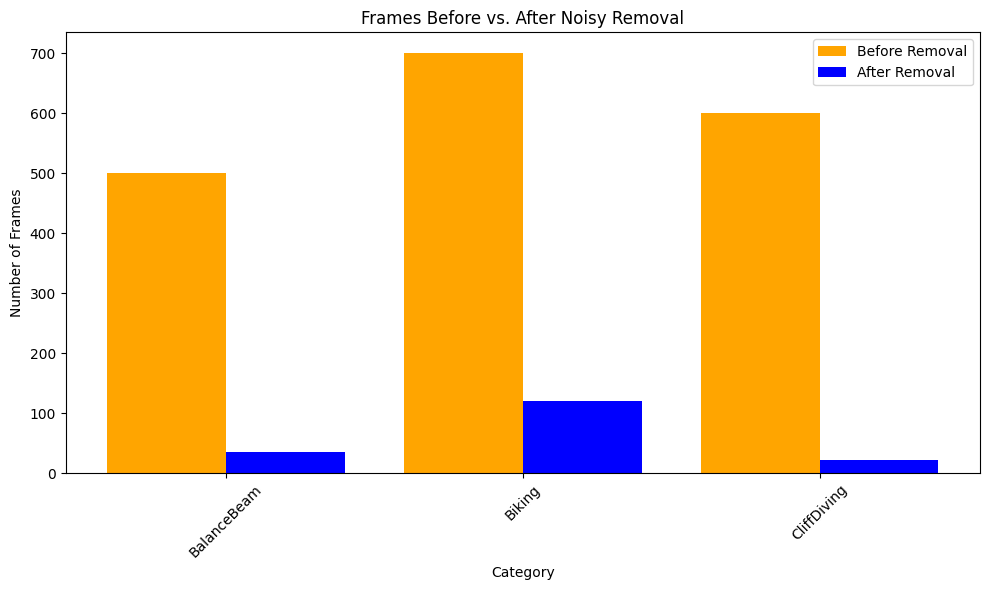

INFO: Plotted frame counts before and after noise removal.


In [101]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import logging

frame_dir = "data/frames"

# Recount the frames after noise removal
post_removal_counts = {}
for category in os.listdir(frame_dir):
    category_path = os.path.join(frame_dir, category)
    if os.path.isdir(category_path):
        post_removal_counts[category] = len(os.listdir(category_path))

#  side-by-side bar chart
common_categories = list(pre_removal_counts.keys())
pre_values = [pre_removal_counts.get(cat, 0) for cat in common_categories]
post_values = [post_removal_counts.get(cat, 0) for cat in common_categories]

x = range(len(common_categories))
bar_width = 0.4

plt.figure(figsize=(10,6))
plt.bar(x, pre_values, width=bar_width, label='Before Removal', color='orange')
plt.bar([i + bar_width for i in x], post_values, width=bar_width, label='After Removal', color='blue')
plt.xticks([i + bar_width/2 for i in x], common_categories, rotation=45)
plt.title("Frames Before vs. After Noisy Removal")
plt.xlabel("Category")
plt.ylabel("Number of Frames")
plt.legend()
plt.tight_layout()
plt.show()

logging.info("Plotted frame counts before and after noise removal.")

Format Frames

In [102]:
import cv2
import os
import logging

def resize_and_convert(frame_path, output_size=(224, 224)):
    frame = cv2.imread(frame_path)
    if frame is None:
        logging.warning(f"Could not read frame for resizing: {frame_path}")
        return
    resized_frame = cv2.resize(frame, output_size)
    cv2.imwrite(frame_path, resized_frame)

frame_dir = "data/frames"

for category in os.listdir(frame_dir):
    category_dir = os.path.join(frame_dir, category)
    if not os.path.isdir(category_dir):
        continue

    for frame_file in os.listdir(category_dir):
        frame_path = os.path.join(category_dir, frame_file)
        if os.path.isfile(frame_path):
            resize_and_convert(frame_path)

logging.info("Frame formatting (resizing/conversion) completed.")

INFO: Frame formatting (resizing/conversion) completed.


Montage of Resized Frames

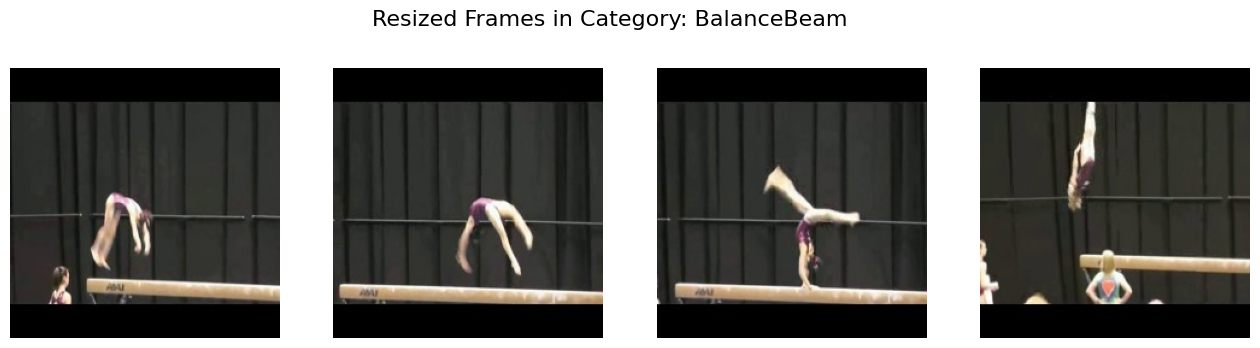

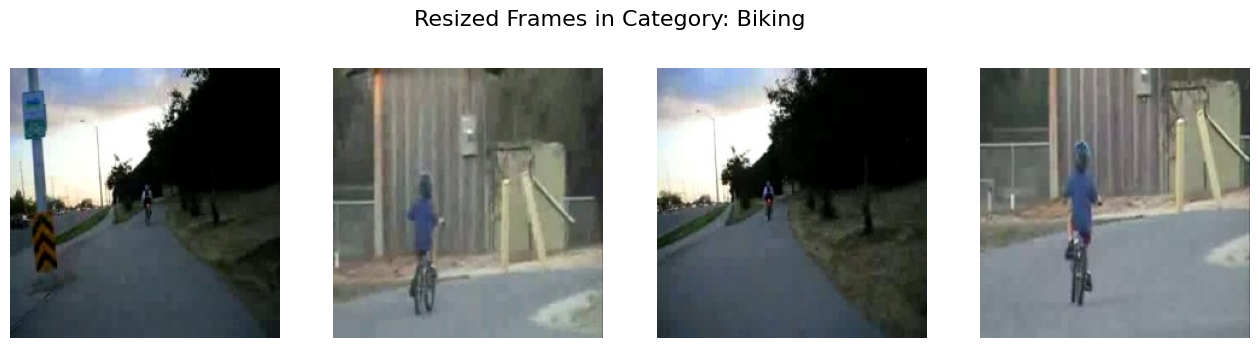

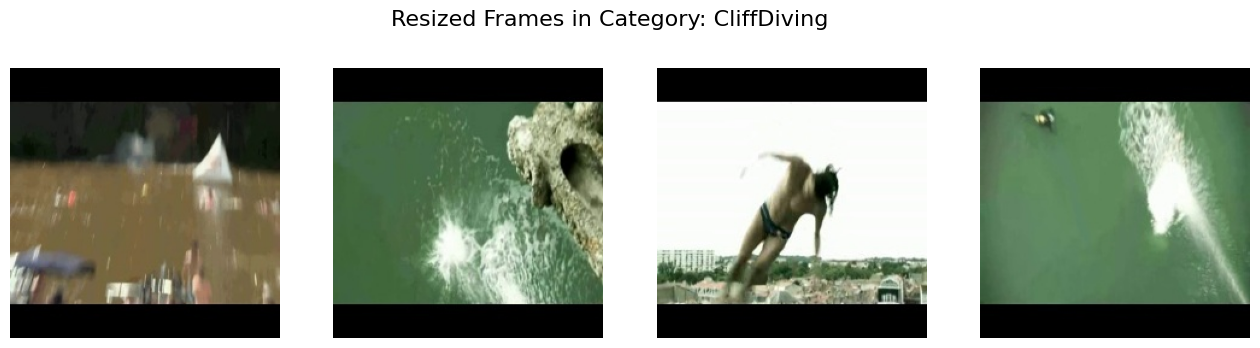

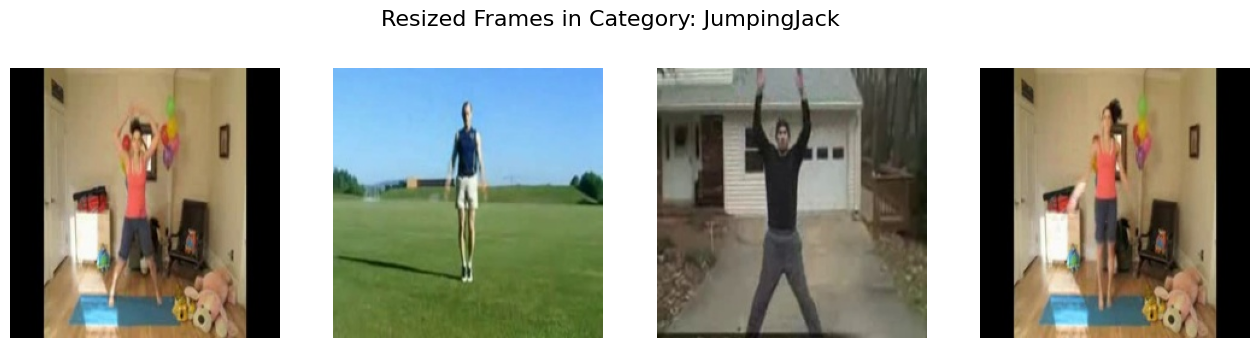

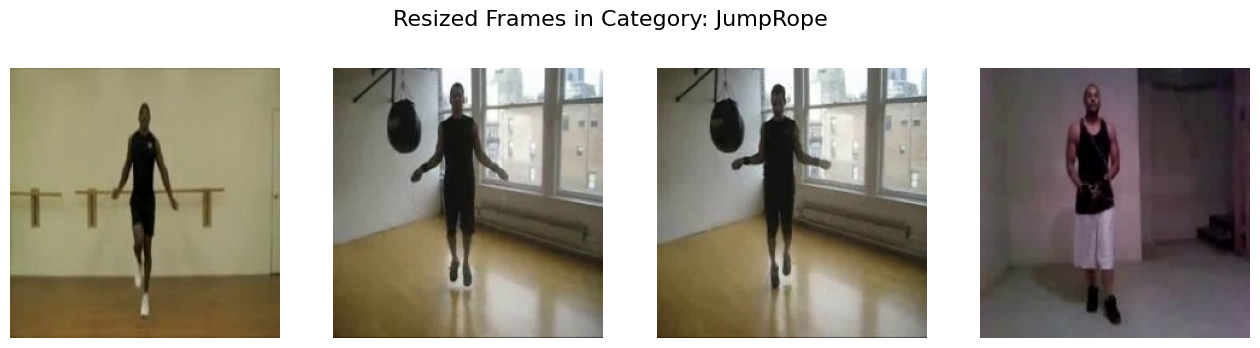

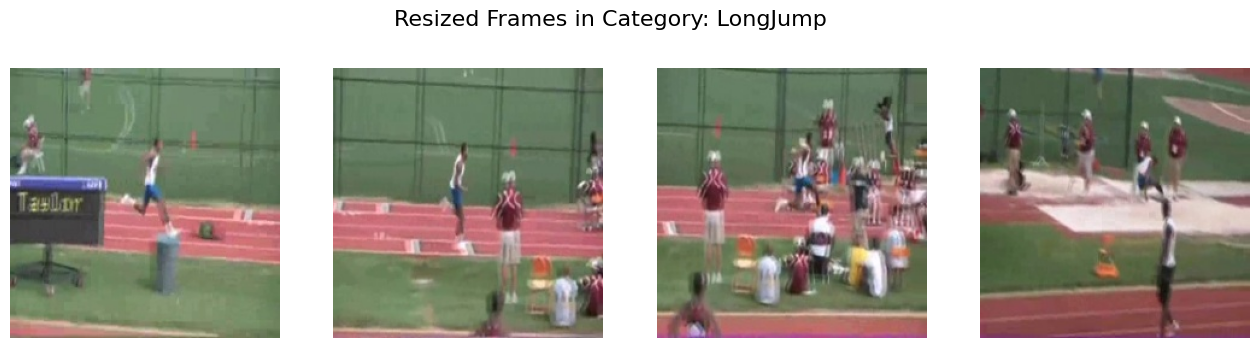

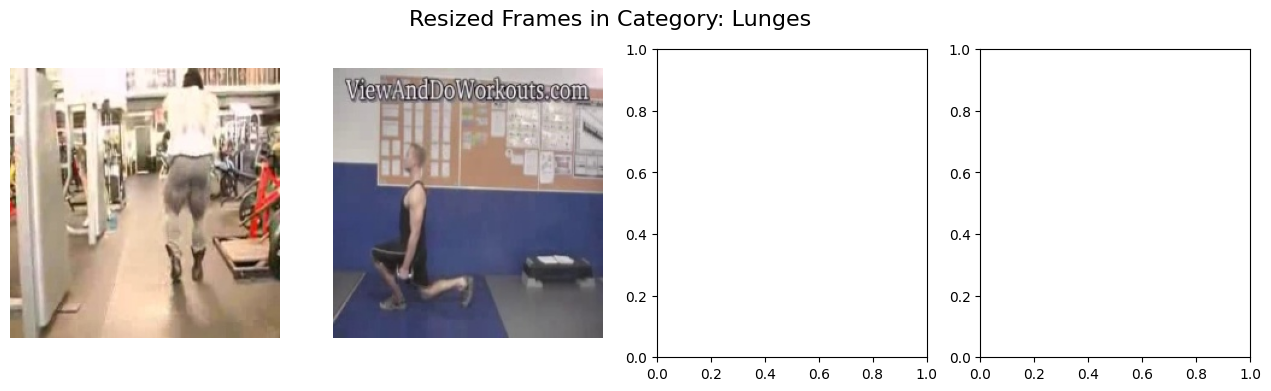

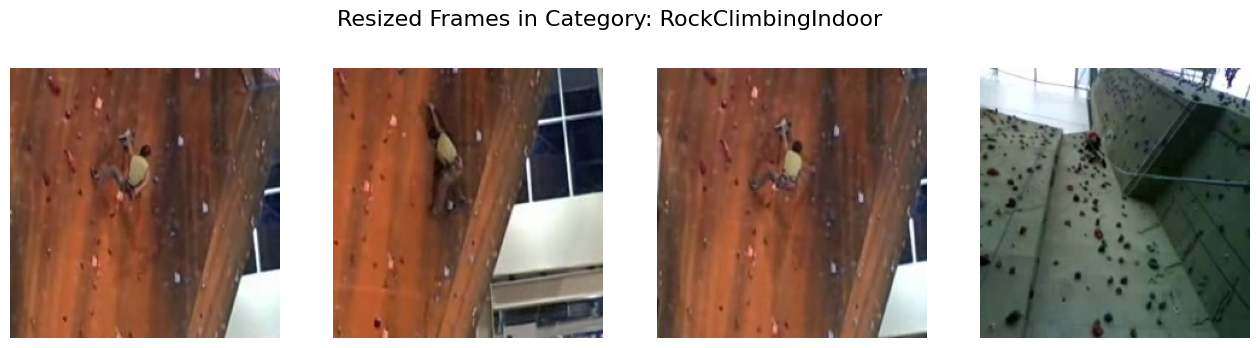

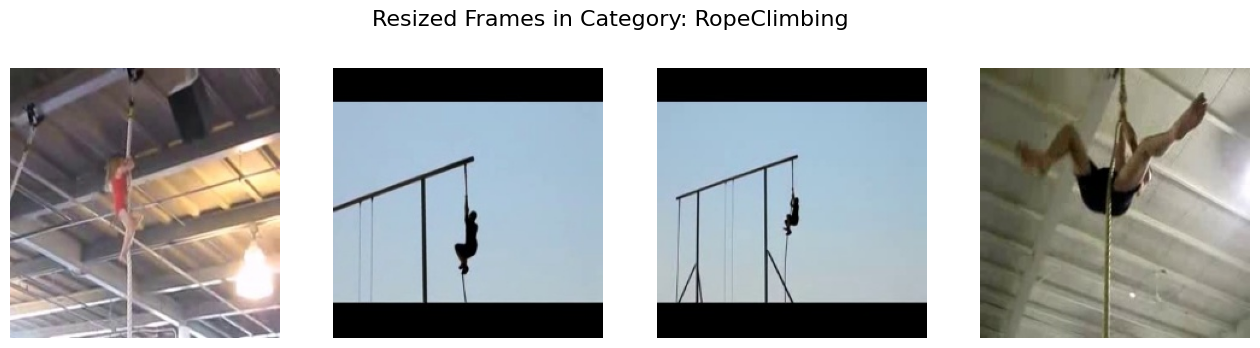

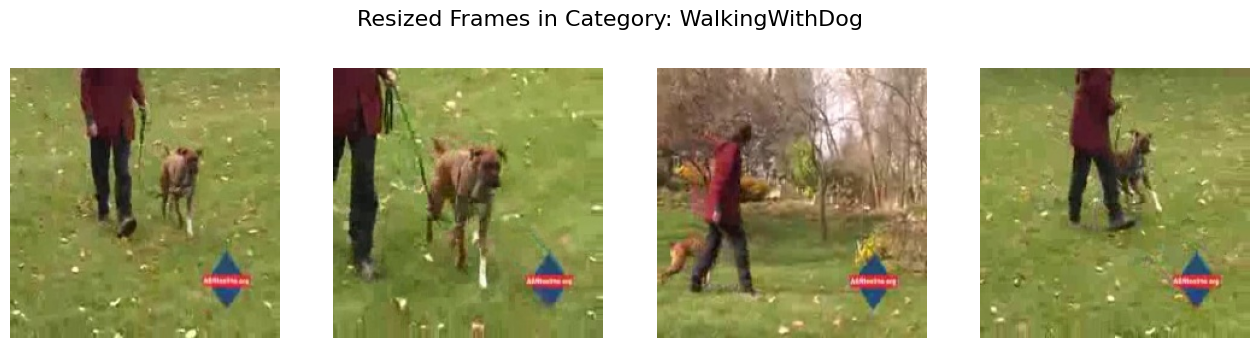

INFO: Displayed random sample of resized frames.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import logging

def show_random_resized_frames(frame_dir, num_frames=4):
    categories = [cat for cat in os.listdir(frame_dir) if os.path.isdir(os.path.join(frame_dir, cat))]

    for category in categories:
        category_path = os.path.join(frame_dir, category)
        all_frames = os.listdir(category_path)
        if not all_frames:
            continue

        random.shuffle(all_frames)
        sample_frames = all_frames[:num_frames]

        fig, axes = plt.subplots(1, num_frames, figsize=(4*num_frames, 4))
        fig.suptitle(f"Resized Frames in Category: {category}", fontsize=16)

        for i, frame_file in enumerate(sample_frames):
            frame_path = os.path.join(category_path, frame_file)
            frame = cv2.imread(frame_path)
            if frame is not None:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
            axes[i].axis('off')
        plt.show()

show_random_resized_frames("data/frames", num_frames=4)
logging.info("Displayed random sample of resized frames.")


Extract Features

In [104]:
import numpy as np
import os
import logging
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img

model = VGG16(weights="imagenet", include_top=False)
features_dir = "data/features"
frame_dir = "data/frames"

for category in os.listdir(frame_dir):
    category_dir = os.path.join(frame_dir, category)
    if not os.path.isdir(category_dir):
        continue

    category_features_dir = os.path.join(features_dir, category)
    os.makedirs(category_features_dir, exist_ok=True)

    for frame_file in os.listdir(category_dir):
        frame_path = os.path.join(category_dir, frame_file)
        if not os.path.isfile(frame_path):
            continue

        try:
            img = load_img(frame_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            features = model.predict(img_array)

            feature_path = os.path.join(category_features_dir, f"{frame_file}.npy")
            np.save(feature_path, features)

        except Exception as e:
            logging.error(f"Error processing {frame_path}: {e}")

logging.info("Feature extraction completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

INFO: Feature extraction completed.


Sequence Preparation

In [105]:
import os
import numpy as np
import logging

def create_fixed_length_sequences(features_dir, sequence_length=16):
    for category in os.listdir(features_dir):
        category_path = os.path.join(features_dir, category)
        if not os.path.isdir(category_path):
            continue

        frames = sorted(os.listdir(category_path))
        all_sequences = []

        for i in range(0, len(frames) - sequence_length + 1, sequence_length):
            seq_data = []
            for j in range(i, i + sequence_length):
                frame_file = frames[j]
                frame_path = os.path.join(category_path, frame_file)
                data = np.load(frame_path)

                if data.ndim == 4 and data.shape[0] == 1:
                    data = data[0]

                data = data.flatten()
                seq_data.append(data)

            seq_array = np.stack(seq_data, axis=0)
            all_sequences.append(seq_array)

        sequences_path = os.path.join(features_dir, f"{category}_sequences.npy")
        np.save(sequences_path, all_sequences)
        if all_sequences:
            logging.info(f"Saved {len(all_sequences)} sequences for '{category}' with shape {seq_array.shape}.")
        else:
            logging.info(f"No valid sequences were generated for '{category}'.")

features_dir = "data/features"
create_fixed_length_sequences(features_dir, sequence_length=16)
logging.info("Sequence preparation completed.")

INFO: Saved 2 sequences for 'BalanceBeam' with shape (16, 25088).
INFO: Saved 7 sequences for 'Biking' with shape (16, 25088).
INFO: Saved 1 sequences for 'CliffDiving' with shape (16, 25088).
INFO: No valid sequences were generated for 'HandstandWalking'.
INFO: Saved 1 sequences for 'JumpingJack' with shape (16, 25088).
INFO: Saved 6 sequences for 'JumpRope' with shape (16, 25088).
INFO: Saved 2 sequences for 'LongJump' with shape (16, 25088).
INFO: No valid sequences were generated for 'Lunges'.
INFO: Saved 10 sequences for 'RockClimbingIndoor' with shape (16, 25088).
INFO: Saved 4 sequences for 'RopeClimbing' with shape (16, 25088).
INFO: Saved 3 sequences for 'WalkingWithDog' with shape (16, 25088).
INFO: Sequence preparation completed.


Sequence Distribution Visualization

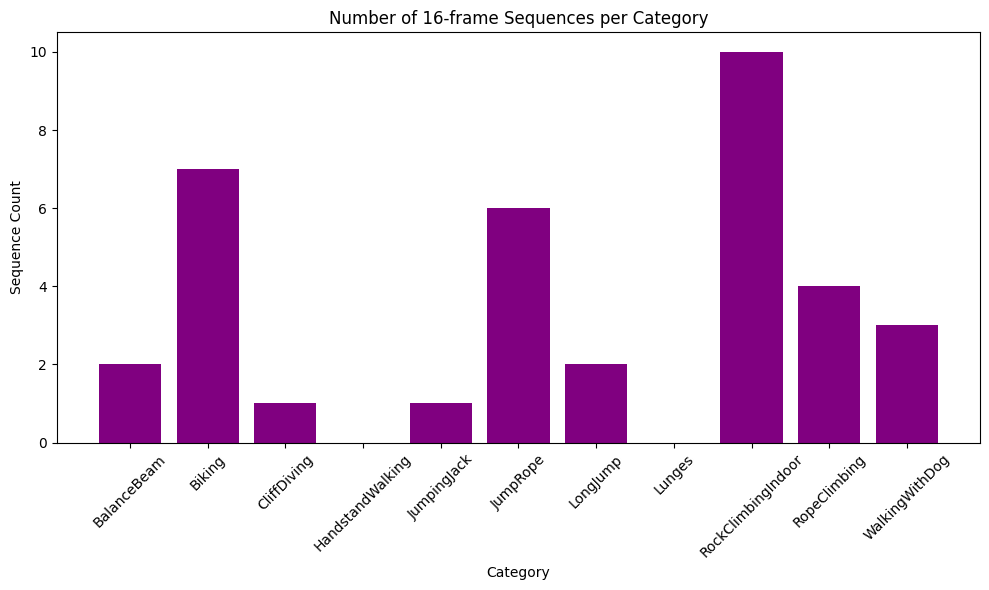

INFO: Plotted distribution of sequence counts per category.


In [106]:
import numpy as np
import os
import matplotlib.pyplot as plt
import logging

sequence_length = 16
features_dir = "data/features"

category_sequence_counts = {}

for category in os.listdir(features_dir):
    if category.endswith("_sequences.npy"):
        # saved file of sequences
        category_name = category.replace("_sequences.npy", "")
        sequences_path = os.path.join(features_dir, category)
        if os.path.isfile(sequences_path):
            sequences = np.load(sequences_path, allow_pickle=True)
            category_sequence_counts[category_name] = len(sequences)

# number of sequences per category
cats = list(category_sequence_counts.keys())
counts = list(category_sequence_counts.values())

plt.figure(figsize=(10,6))
plt.bar(cats, counts, color='purple')
plt.title(f"Number of {sequence_length}-frame Sequences per Category")
plt.xlabel("Category")
plt.ylabel("Sequence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

logging.info("Plotted distribution of sequence counts per category.")

Combine sequences into arrays and map them to train/val/test using your split files.

In [107]:
# Combine sequences into arrays and randomly split (70/15/15)
import os
import numpy as np
import logging

category_to_label = {
    "BalanceBeam": 0,
    "Biking": 1,
    "CliffDiving": 2,
    "HandstandWalking": 3,
    "JumpingJack": 4,
    "JumpRope": 5,
    "LongJump": 6,
    "Lunges": 7,
    "RockClimbingIndoor": 8,
    "RopeClimbing": 9,
    "WalkingWithDog": 10
}

features_dir = "data/features"

X_train_list, y_train_list = [], []
X_val_list,   y_val_list   = [], []
X_test_list,  y_test_list  = [], []

for file in os.listdir(features_dir):
    if not file.endswith("_sequences.npy"):
        continue

    category_name = file.replace("_sequences.npy", "")
    if category_name not in category_to_label:
        logging.warning(f"Unknown category: {category_name}. Skipping...")
        continue

    sequences_path = os.path.join(features_dir, file)
    all_seqs = np.load(sequences_path, allow_pickle=True)

    # Print shape to debug
    print(f"DEBUG: {file} has shape {all_seqs.shape}")

    # Skip if empty or rank != 3
    if all_seqs.size == 0 or len(all_seqs.shape) != 3:
        logging.warning(f"Skipping {file} due to shape {all_seqs.shape}")
        continue

    # all_seqs => shape (N, 16, 25088)
    label = category_to_label[category_name]
    y_all_cat = np.array([label] * len(all_seqs))

    # 70/15/15 random split for this category
    indices = np.arange(len(all_seqs))
    np.random.shuffle(indices)
    all_seqs = all_seqs[indices]
    y_all_cat = y_all_cat[indices]

    n_total = len(all_seqs)
    n_train = int(0.7 * n_total)
    n_val   = int(0.15 * n_total)
    n_test  = n_total - (n_train + n_val)

    X_cat_train = all_seqs[:n_train]
    y_cat_train = y_all_cat[:n_train]

    X_cat_val   = all_seqs[n_train:n_train+n_val]
    y_cat_val   = y_all_cat[n_train:n_train+n_val]

    X_cat_test  = all_seqs[n_train+n_val:]
    y_cat_test  = y_all_cat[n_train+n_val:]

    X_train_list.append(X_cat_train)
    y_train_list.append(y_cat_train)

    X_val_list.append(X_cat_val)
    y_val_list.append(y_cat_val)

    X_test_list.append(X_cat_test)
    y_test_list.append(y_cat_test)

# concatenate
if X_train_list:
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
else:
    X_train = np.array([])
    y_train = np.array([])

if X_val_list:
    X_val = np.concatenate(X_val_list, axis=0)
    y_val = np.concatenate(y_val_list, axis=0)
else:
    X_val = np.array([])
    y_val = np.array([])

if X_test_list:
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)
else:
    X_test = np.array([])
    y_test = np.array([])

logging.info(f"Final shapes: X_train={X_train.shape}, y_train={y_train.shape}")
logging.info(f"Final shapes: X_val={X_val.shape},   y_val={y_val.shape}")
logging.info(f"Final shapes: X_test={X_test.shape},  y_test={y_test.shape}")

INFO: Final shapes: X_train=(21, 16, 25088), y_train=(21,)
INFO: Final shapes: X_val=(2, 16, 25088),   y_val=(2,)
INFO: Final shapes: X_test=(13, 16, 25088),  y_test=(13,)


DEBUG: BalanceBeam_sequences.npy has shape (2, 16, 25088)
DEBUG: Biking_sequences.npy has shape (7, 16, 25088)
DEBUG: CliffDiving_sequences.npy has shape (1, 16, 25088)
DEBUG: HandstandWalking_sequences.npy has shape (0,)
DEBUG: JumpingJack_sequences.npy has shape (1, 16, 25088)
DEBUG: JumpRope_sequences.npy has shape (6, 16, 25088)
DEBUG: LongJump_sequences.npy has shape (2, 16, 25088)
DEBUG: Lunges_sequences.npy has shape (0,)
DEBUG: RockClimbingIndoor_sequences.npy has shape (10, 16, 25088)
DEBUG: RopeClimbing_sequences.npy has shape (4, 16, 25088)
DEBUG: WalkingWithDog_sequences.npy has shape (3, 16, 25088)


Dataset Preparation (Zipping)

In [108]:
import shutil
import logging

def zip_processed_dataset(dataset_dir="data/features", zip_filename="processed_dataset.zip"):
    """
    Zips the final processed dataset directory.
    """
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', dataset_dir)
    logging.info(f"Zipped final processed dataset into {zip_filename}")

zip_processed_dataset("data/features", "final_processed_dataset.zip")
logging.info("Final dataset zipped and ready for sharing.")

INFO: Zipped final processed dataset into final_processed_dataset.zip
INFO: Final dataset zipped and ready for sharing.


Part III: Network Architecture 

Define and Summarize the Model

In [109]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Model Definition & Summary (E1)
# Define an LSTM-based architecture for our video sequences.



sequence_length = X_train.shape[1]
feature_dim     = X_train.shape[2]
num_classes     = 11                # we have 11 categories

# Sequential model
model = models.Sequential()

# LSTM layer: 128 units, set return_sequences=False
model.add(layers.LSTM(128, input_shape=(sequence_length, feature_dim), return_sequences=False))

# Dense layer with 64 nodes for additional learning capacity
model.add(layers.Dense(64, activation='relu'))

# Final output layer with 'num_classes' nodes and softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))

print("\n==================== MODEL SUMMARY ====================")
model.summary()  # (E1) Print the model summary (layers, output shapes, param counts)

# Compile the Model (E3: Hyperparameters)
# I chose 'sparse_categorical_crossentropy' if 'y_train' is integer-coded;
# otherwise 'categorical_crossentropy' if one-hot.
# Adam is a common optimizer with a default or 0.001 learning rate.
# EarlyStopping helps prevent overfitting by monitoring 'val_loss'.

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\nModel compiled with:")
print("- Loss: sparse_categorical_crossentropy")
print("- Optimizer: Adam (learning_rate=0.001)")
print("- EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)")


==================== MODEL SUMMARY ====================


C:\Users\MayCooperStation\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │    12,911,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,920,075 (49.29 MB)

 Trainable params: 12,920,075 (49.29 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled with:
- Loss: sparse_categorical_crossentropy
- Optimizer: Adam (learning_rate=0.001)
- EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Train the Model and Generate Confusion Matrix


==================== TRAINING START ====================
Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.1052 - loss: 2.4125 - val_accuracy: 0.5000 - val_loss: 1.5640
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.5159 - loss: 1.6866 - val_accuracy: 1.0000 - val_loss: 0.9995
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.4633 - loss: 1.4401 - val_accuracy: 1.0000 - val_loss: 0.8226
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.7897 - loss: 1.1812 - val_accuracy: 1.0000 - val_loss: 0.6861
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.9474 - loss: 0.9928 - val_accuracy: 1.0000 - val_loss: 0.5693
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 1.0000 - loss: 0.8446 - val_accuracy: 1.0000 - val_loss: 0.4610
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 1.0000 - loss: 0.7273 - val_accuracy: 1.0000 - val_loss: 0.3855
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy

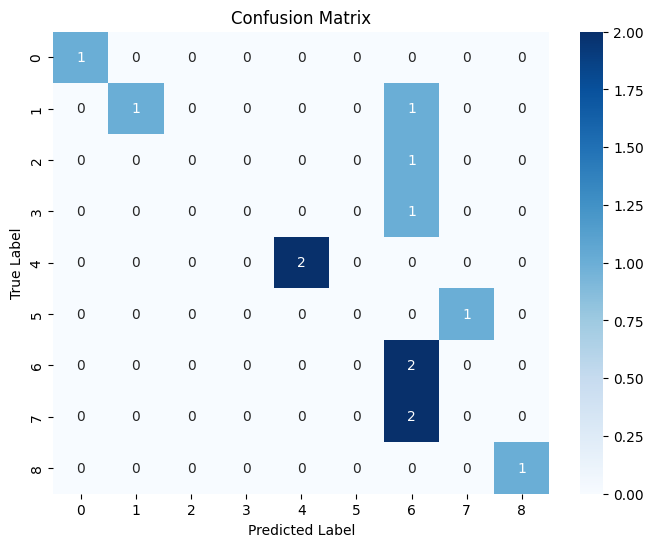

In [110]:
print("\n==================== TRAINING START ====================")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,          # an upper bound
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)
print("===================== TRAINING END =====================\n")

# plot performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# (E4) Confusion Matrix
import numpy as np
y_pred_prob = model.predict(X_test)
y_pred      = np.argmax(y_pred_prob, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("\n================ CONFUSION MATRIX ================")
print(cm)

# confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Model Evaluation (F1–F3)


Model training completed in 30 epochs (due to early stopping).
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


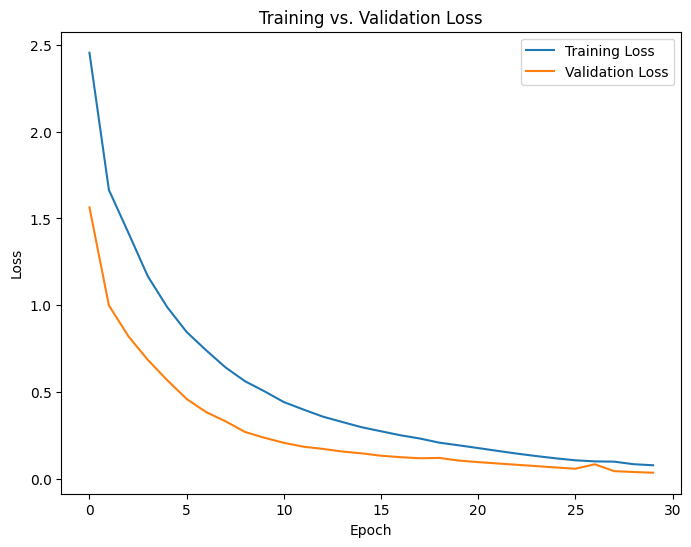


Test Loss: 1.3706 | Test Accuracy: 0.5385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

==================== CLASSIFICATION REPORT ====================
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000   1.000000
1              1.000000  0.500000  0.666667   2.000000
2              0.000000  0.000000  0.000000   1.000000
4              0.000000  0.000000  0.000000   1.000000
5              1.000000  1.000000  1.000000   2.000000
6              0.000000  0.000000  0.000000   1.000000
8              0.285714  1.000000  0.444444   2.000000
9              0.000000  0.000000  0.000000   2.000000
10             1.000000  1.000000  1.000000   1.000000
accuracy       0.538462  0.538462  0.538462   0.538462
macro avg      0.476190  0.500000  0.456790  13.000000
weighted avg   0.505495  0.538462  0.478632  13.000000


In [111]:
# F1a: Show impact of EarlyStopping & final training epoch
final_epoch_count = len(history.history['loss'])
print(f"Model training completed in {final_epoch_count} epochs (due to early stopping).")

# F1b: Compare train vs. validation using accuracy and/or loss
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

# F1c: Plot training vs. validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# F3: Predictive accuracy on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# classification report
from sklearn.metrics import classification_report
import pandas as pd

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()

print("\n==================== CLASSIFICATION REPORT ====================")
print(df_report)

Save the Trained Network

In [112]:
# Save the trained model
model_save_path = "final_model.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to final_model.keras
